**Flux Plots for Different Deployments**

This will try to visualize flux on frying pan shoals over the five deployments.


In [21]:
### Code to read in h5 files as detailed in the first guidebook
# Import necessary packages
import sys

sys.path.append(r"C:\Users\lwlav\.vscode\repo\BOEM-Oak-Island\Post_Processing_Scripts")
from spectral_sediment import lowpass_filter, goring_nikora_despike
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy import signal
import glob

deployment_num = [1, 2, 3, 4, 5]
sensor_spot = "S"
# directory_initial_user_path = r"/Volumes/BOEM/"  # Katherine
# directory_initial_user_path = r"/Volumes/kanarde/BOEM/"  # Brooke
directory_initial_user_path = r"Z:/"  # Levi

In [43]:
# Import bulkstats and create dictionary for each sensor
for dep in deployment_num:
    initpath = os.path.join(directory_initial_user_path, f"/deployment_{dep}/BulkStats")
    sensor_id = glob.glob(os.path.join(initpath, f"{sensor_spot}*"))[0]
    sensor_location = os.path.basename(sensor_id)
    sensor_location = sensor_location.split("_")[0]  # Extract S0 or S1
    print(f"Processing {sensor_location}...")
    files = ["DepthAveragedFlowDirection", "DepthAveragedCurrentVelocity", "Vertavg"]
    waves = {}
    for file in files:
        file_path = os.path.join(sensor_id, file)  # file path
        df = pd.read_hdf(file_path)  # read the file into a Pandas dataframe
        file_name = file.split(".")[0]  # file name
        print(file_name)
        waves[file_name] = df  # store dataframe
    globals()[f"waves_{sensor_location}_{dep}"] = waves

Processing S0...
DepthAveragedFlowDirection
DepthAveragedCurrentVelocity
Vertavg
Processing S0...
DepthAveragedFlowDirection
DepthAveragedCurrentVelocity
Vertavg
Processing S0...
DepthAveragedFlowDirection
DepthAveragedCurrentVelocity
Vertavg
Processing S1...
DepthAveragedFlowDirection
DepthAveragedCurrentVelocity
Vertavg
Processing S1...
DepthAveragedFlowDirection
DepthAveragedCurrentVelocity
Vertavg


In [44]:
import numpy as np
import matplotlib.pyplot as plt


def plot_orbital_bars(waves, title=None, cmap="viridis", normalize_velocity=False):
    """
    Polar orbital bar plot.

    Parameters
    ----------
    waves : dict
        Dictionary with keys:
        - DepthAveragedFlowDirection
        - DepthAveragedCurrentVelocity
        - Vertavg

    title : str
        Plot title

    cmap : str
        Matplotlib colormap

    normalize_velocity : bool
        Normalize bar length
    """

    # ----------------------------------
    # Extract data
    # ----------------------------------

    direction = waves["DepthAveragedFlowDirection"].values.squeeze()
    velocity = waves["DepthAveragedCurrentVelocity"].values.squeeze()
    vertavg = waves["Vertavg"].values.squeeze()

    #Downsample vert avg to match dir and vel length
    if len(vertavg) > len(direction):
        step = len(vertavg) // len(direction)
        #Average chunks together
        vertavg = np.array([np.mean(vertavg[i:i+step]) for i in range(0, len(vertavg), step)])


    # ----------------------------------
    # Polar conversion
    # ----------------------------------

    theta = np.deg2rad(direction)
    radii = velocity.copy()

    if normalize_velocity:
        radii = radii / np.nanmax(radii)

    width = 2 * np.pi / len(theta)

    # ----------------------------------
    # Bin Data into 10 degree bins
    # ----------------------------------
    bins = np.arange(0, 360 + 10, 10)
    bin_indices = np.digitize(direction, bins) - 1  # Get bin
    bin_vertavg = np.array([np.nanmean(vertavg[bin_indices == i]) for i in range(len(bins) - 1)])
    bin_theta = np.deg2rad((bins[:-1] + bins[1:]) / 2)  # Bin centers
    bin_width = np.deg2rad(10)  # Bin width
    bin_vel = np.array([np.nanmean(velocity[bin_indices == i]) for i in range(len(bins) - 1)])
    
    # ----------------------------------
    # Colors from Vertavg
    # ----------------------------------

    norm = plt.Normalize(np.nanmin(bin_vertavg), np.nanmax(bin_vertavg))
    cmap = plt.colormaps.get_cmap(cmap)
    colors = cmap(norm(bin_vertavg))

    # ----------------------------------
    # Plot
    # ----------------------------------
    print(bin_theta.shape, bin_vel.shape, bin_width.shape, colors.shape)
    fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 8))

    bars = ax.bar(bin_theta, bin_vel, width=bin_width, bottom=0, color=colors, alpha=0.8)
    
    # ----------------------------------
    # Formatting
    # ----------------------------------

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    if title:
        ax.set_title(title)

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    plt.colorbar(sm, ax=ax, label="Vertavg Intensity (dB)")
    plt.xlabel("Flow Direction (degrees)")
    plt.ylabel("Depth-Averaged Current Velocity (m/s)")
    plt.tight_layout()
    plt.show()

(36,) (36,) () (36, 4)


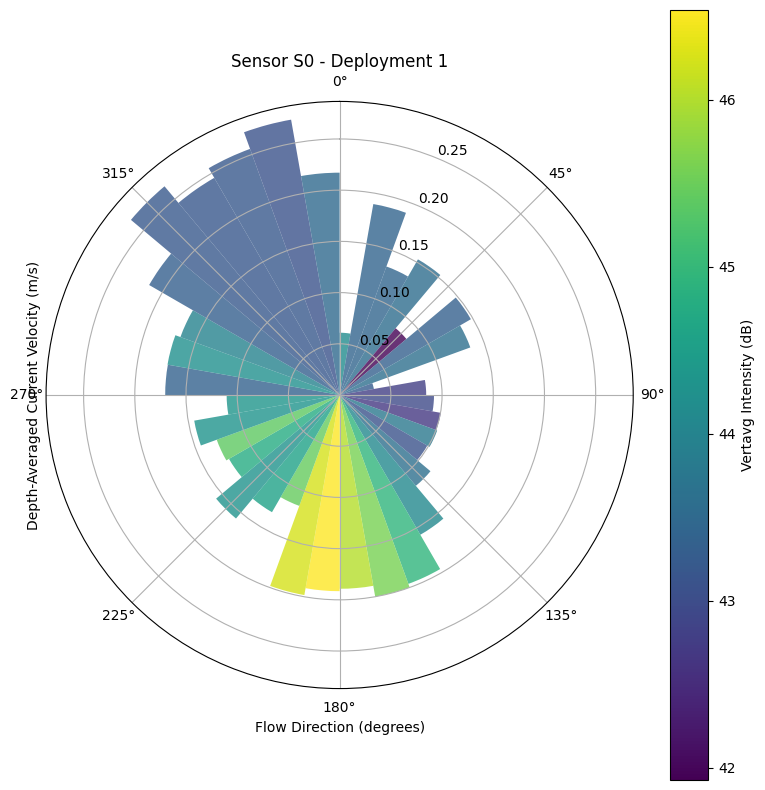

C:\Users\lwlav\AppData\Local\Temp\ipykernel_42552\320816048.py:59: RuntimeWarning: Mean of empty slice
  bin_vertavg = np.array([np.nanmean(vertavg[bin_indices == i]) for i in range(len(bins) - 1)])
C:\Users\lwlav\AppData\Local\Temp\ipykernel_42552\320816048.py:62: RuntimeWarning: Mean of empty slice
  bin_vel = np.array([np.nanmean(velocity[bin_indices == i]) for i in range(len(bins) - 1)])


(36,) (36,) () (36, 4)


ValueError: 'vertices' must be 2D with shape (N, 2), but your input has shape (0,)

<Figure size 800x800 with 2 Axes>

(36,) (36,) () (36, 4)


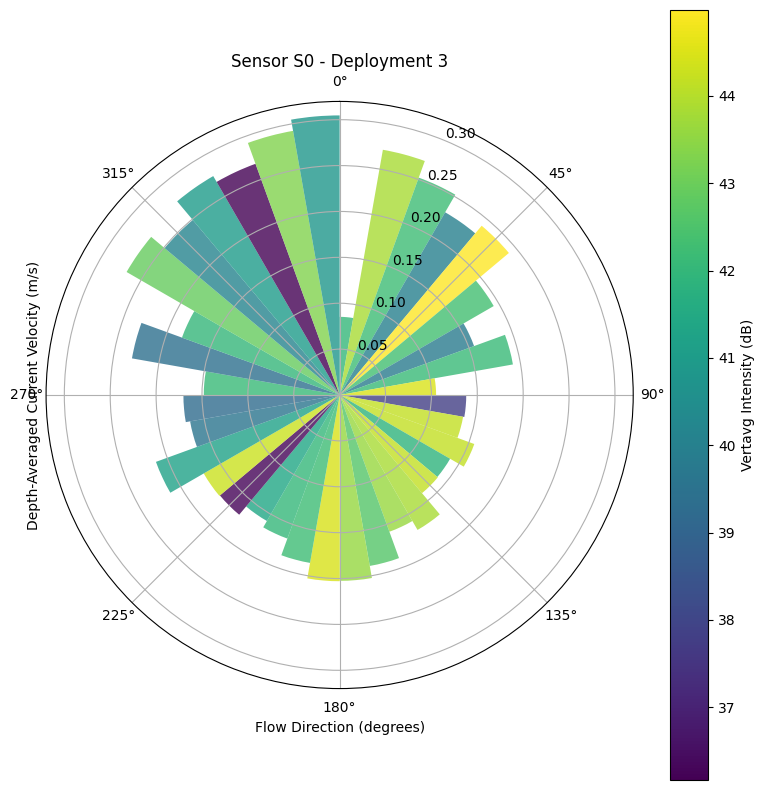

KeyError: 'waves_S0_4'

In [46]:
global_variable_names = list(globals().keys())
for dep in deployment_num:
    for sensor_location in ['S0']:
        plot_orbital_bars(globals()[f"waves_{sensor_location}_{dep}"], title=f"Sensor {sensor_location} - Deployment {dep}", normalize_velocity=True)